# Applying Machine Learning Operations to Hyperspectral Images

In [1]:
# get path from .env file
import os
from dotenv import dotenv_values
import pandas as pd
config = dotenv_values(".env")
data_dir = config["DATA_DIR"]
working_dir = config["WORKING_DIR"]
# show all the folders and files in the working directory in a tree structure
os.chdir(data_dir)
os.listdir(data_dir)

['annotations', 'Avocado', 'Kaki', 'Kiwi', 'Mango', 'Papaya']

In [1]:
# import depthwise separable conv2d layer
import tensorflow as tf
keras = tf.keras
from keras.models import Sequential
from keras.layers import DepthwiseConv2D, AveragePooling2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Conv2D, SeparableConvolution2D, Activation, Input, Add, Lambda, concatenate, Attention
from keras.activations import sigmoid
from keras.backend import resize_images
from keras_adabound import AdaBound
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from hsi_datagen import HSI_datagen
from IPython.display import Image
# import model checkpoint
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import json

In [2]:
# check gpu availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 855942970743642021
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3643801600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16975138452197722580
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Introduction

## DeepHSI Dataset

### Data Insights

In [2]:
import json
train_all_v2 = json.load(open("./annotations/train_only_labeled_v2.json"))
val_v2 = json.load(open("./annotations/val_v2.json"))
test_v2 = json.load(open("./annotations/test_v2.json"))

In [5]:
train_all_v2.keys()

dict_keys(['info', 'cameras', 'days', 'records', 'annotations'])

In [6]:
VIS_wavelengths = train_all_v2['cameras'][0]['wavelengths']
NIR_wavelengths = train_all_v2['cameras'][1]['wavelengths']
VIS_COR_wavelengths = train_all_v2['cameras'][2]['wavelengths']

train data preparation

In [3]:
train_records_df = pd.DataFrame(train_all_v2['records'])
# files attribute is a dictionary with keys: header_file, and data_file, convert these into seperate columns
train_records_df['header_file'] = train_records_df['files'].apply(lambda x: x['header_file'])
train_records_df['data_file'] = train_records_df['files'].apply(lambda x: x['data_file'])
# remove the files column
train_records_df.drop('files', axis=1, inplace=True)
train_records_df.head()

,id,fruit,side,day,camera_type,header_file,data_file
0,0,Avocado,front,day_01,NIR,Avocado/NIR/day_01/avocado_day_01_20_front.hdr,Avocado/NIR/day_01/avocado_day_01_20_front.bin
1,1,Avocado,front,day_01,VIS,Avocado/VIS/day_01/avocado_day_01_20_front.hdr,Avocado/VIS/day_01/avocado_day_01_20_front.bin
2,2,Avocado,back,day_01,NIR,Avocado/NIR/day_01/avocado_day_01_20_back.hdr,Avocado/NIR/day_01/avocado_day_01_20_back.bin
3,3,Avocado,back,day_01,VIS,Avocado/VIS/day_01/avocado_day_01_20_back.hdr,Avocado/VIS/day_01/avocado_day_01_20_back.bin
4,4,Avocado,front,day_01,NIR,Avocado/NIR/day_01/avocado_day_01_30_front.hdr,Avocado/NIR/day_01/avocado_day_01_30_front.bin


In [5]:
train_annotations_df = pd.DataFrame(train_all_v2['annotations'])
train_annotations_df.head()

,id,record_id,init_weight,end_weight,storage_days,firmness,comment,ripeness_state,ripeness_state_fine
0,0,0,227,227.0,0,19750.0,None,unripe,unripe
1,1,1,227,227.0,0,19750.0,None,unripe,unripe
2,2,2,227,227.0,0,19750.0,None,unripe,unripe
3,3,3,227,227.0,0,19750.0,None,unripe,unripe
4,4,4,252,252.0,0,18250.0,None,unripe,unripe


In [6]:
# merge the two dataframes
train_df = pd.merge(train_records_df, train_annotations_df, on='id')
train_df.head()

,id,fruit,side,day,camera_type,header_file,data_file,record_id,init_weight,end_weight,storage_days,firmness,comment,ripeness_state,ripeness_state_fine
0,0,Avocado,front,day_01,NIR,Avocado/NIR/day_01/avocado_day_01_20_front.hdr,Avocado/NIR/day_01/avocado_day_01_20_front.bin,0,227,227.0,0,19750.0,None,unripe,unripe
1,1,Avocado,front,day_01,VIS,Avocado/VIS/day_01/avocado_day_01_20_front.hdr,Avocado/VIS/day_01/avocado_day_01_20_front.bin,1,227,227.0,0,19750.0,None,unripe,unripe
2,2,Avocado,back,day_01,NIR,Avocado/NIR/day_01/avocado_day_01_20_back.hdr,Avocado/NIR/day_01/avocado_day_01_20_back.bin,2,227,227.0,0,19750.0,None,unripe,unripe
3,3,Avocado,back,day_01,VIS,Avocado/VIS/day_01/avocado_day_01_20_back.hdr,Avocado/VIS/day_01/avocado_day_01_20_back.bin,3,227,227.0,0,19750.0,None,unripe,unripe
4,4,Avocado,front,day_01,NIR,Avocado/NIR/day_01/avocado_day_01_30_front.hdr,Avocado/NIR/day_01/avocado_day_01_30_front.bin,4,252,252.0,0,18250.0,None,unripe,unripe


validation data preparation

In [7]:
val_records_df = pd.DataFrame(val_v2['records'])
val_records_df['header_file'] = val_records_df['files'].apply(lambda x: x['header_file'])
val_records_df['data_file'] = val_records_df['files'].apply(lambda x: x['data_file'])
val_records_df.drop('files', axis=1, inplace=True)
val_annotations_df = pd.DataFrame(val_v2['annotations'])
val_df = pd.merge(val_records_df, val_annotations_df, on='id')
val_df.head()

,id,fruit,side,day,camera_type,header_file,data_file,record_id,init_weight,end_weight,storage_days,firmness,comment,ripeness_state,ripeness_state_fine
0,0,Avocado,front,day_03,VIS,Avocado/VIS/day_03/avocado_day_03_13_front.hdr,Avocado/VIS/day_03/avocado_day_03_13_front.bin,0,240,231.0,2,4450.0,None,unripe,unripe
1,1,Avocado,back,day_03,VIS,Avocado/VIS/day_03/avocado_day_03_13_back.hdr,Avocado/VIS/day_03/avocado_day_03_13_back.bin,1,240,231.0,2,4450.0,None,unripe,unripe
2,2,Avocado,front,day_03,NIR,Avocado/NIR/day_03/avocado_day_03_17_front.hdr,Avocado/NIR/day_03/avocado_day_03_17_front.bin,2,242,235.0,2,4650.0,None,unripe,unripe
3,3,Avocado,back,day_03,NIR,Avocado/NIR/day_03/avocado_day_03_17_back.hdr,Avocado/NIR/day_03/avocado_day_03_17_back.bin,3,242,235.0,2,4650.0,None,unripe,unripe
4,4,Kiwi,back,day_03,VIS,Kiwi/VIS/day_03/kiwi_day_03_17_back.hdr,Kiwi/VIS/day_03/kiwi_day_03_17_back.bin,4,117,115.0,2,1050.0,None,perfect,perfect


test data preparation

In [8]:
test_records_df = pd.DataFrame(test_v2['records'])
test_records_df['header_file'] = test_records_df['files'].apply(lambda x: x['header_file'])
test_records_df['data_file'] = test_records_df['files'].apply(lambda x: x['data_file'])
test_records_df.drop('files', axis=1, inplace=True)
test_annotations_df = pd.DataFrame(test_v2['annotations'])
test_df = pd.merge(test_records_df, test_annotations_df, on='id')
test_df.head()

,id,fruit,side,day,camera_type,header_file,data_file,record_id,init_weight,end_weight,storage_days,firmness,comment,ripeness_state,ripeness_state_fine
0,0,Avocado,back,day_03,NIR,Avocado/NIR/day_03/avocado_day_03_05_back.hdr,Avocado/NIR/day_03/avocado_day_03_05_back.bin,0,231,224.0,2,1200.0,None,perfect,ripe
1,1,Avocado,front,day_03,NIR,Avocado/NIR/day_03/avocado_day_03_13_front.hdr,Avocado/NIR/day_03/avocado_day_03_13_front.bin,1,240,231.0,2,4450.0,None,unripe,unripe
2,2,Kiwi,front,day_03,NIR,Kiwi/NIR/day_03/kiwi_day_03_07_front.hdr,Kiwi/NIR/day_03/kiwi_day_03_07_front.bin,2,123,121.0,2,150.0,Could be also ripe,overripe,overripe
3,3,Kiwi,back,day_03,VIS,Kiwi/VIS/day_03/kiwi_day_03_23_back.hdr,Kiwi/VIS/day_03/kiwi_day_03_23_back.bin,3,127,126.0,2,1750.0,None,perfect,ripe
4,4,Kiwi,back,day_04,NIR,Kiwi/NIR/day_04/kiwi_day_04_12_back.hdr,Kiwi/NIR/day_04/kiwi_day_04_12_back.bin,4,124,122.0,3,1150.0,None,perfect,perfect


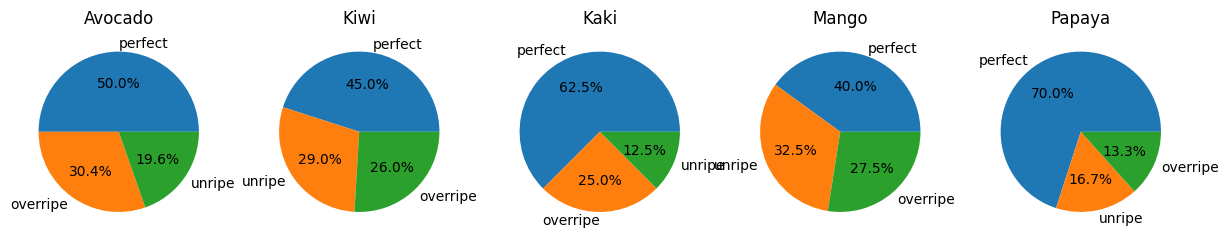

In [12]:
# get the unique fruits 
all_df = pd.concat([train_df, val_df, test_df])
uniques = all_df['fruit'].unique()

# for each fruits show pie chart of ripeness 
# in subplots
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 5, figsize=(15, 15))
axes = axes.flatten()
for i, fruit in enumerate(uniques):
    fruit_df = all_df[all_df['fruit'] == fruit]
    # show percentage of each ripeness state
    agg = fruit_df['ripeness_state'].value_counts().sort_values(ascending=False)
    axes[i].pie(agg, labels=agg.index, autopct='%1.1f%%')
    axes[i].set_title(fruit)
# add legend to the entire figure
plt.show()


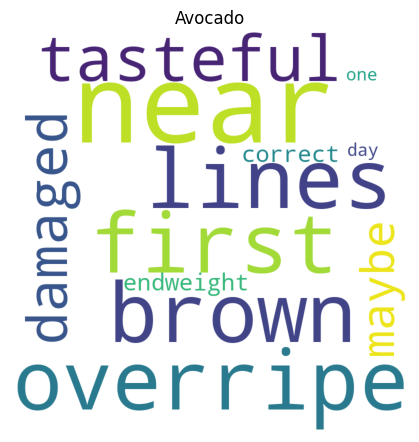

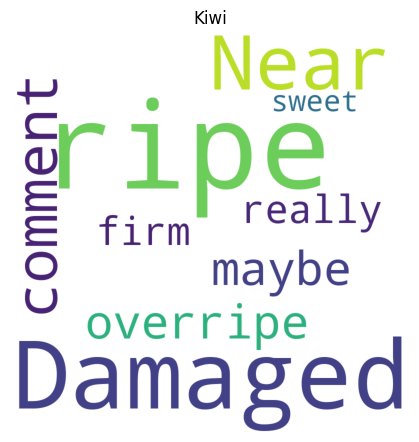

In [11]:
import wordcloud 

# for each fruit show word cloud of the comments
for fruit in uniques:
    fruit_df = train_df[train_df['fruit'] == fruit]
    comments = fruit_df['comment']
    # join all the comments into one string
    comments = comments.str.cat(sep=' ')
    # if there are no comments, skip this fruit
    if comments == '':
        continue
    # create the word cloud
    wc = wordcloud.WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(comments)
    # plot the word cloud
    plt.figure(figsize=(4, 4), facecolor=None)
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(fruit)
    plt.show()

In [12]:
vis_count = len(VIS_wavelengths)
nir_count = len(NIR_wavelengths)
vis_cor_count = len(VIS_COR_wavelengths)
print(f"There are {vis_count} VIS wavelengths, {nir_count} NIR wavelengths, and {vis_cor_count} VIS_COR wavelengths.")
# print list of VIS wavelengths and NIR wavelengths
print("The visible(VIS) wavelengths are :", VIS_wavelengths)
print("The Near Infrared (NIR) wavelengths:", NIR_wavelengths)
print("The corrected visible(VIS_COR) wavelengths:", VIS_COR_wavelengths)

There are 224 VIS wavelengths, 252 NIR wavelengths, and 249 VIS_COR wavelengths.
The visible(VIS) wavelengths are : [397.66, 400.28, 402.9, 405.52, 408.13, 410.75, 413.37, 416.0, 418.62, 421.24, 423.86, 426.49, 429.12, 431.74, 434.37, 437.0, 439.63, 442.26, 444.89, 447.52, 450.16, 452.79, 455.43, 458.06, 460.7, 463.34, 465.98, 468.62, 471.26, 473.9, 476.54, 479.18, 481.83, 484.47, 487.12, 489.77, 492.42, 495.07, 497.72, 500.37, 503.02, 505.67, 508.32, 510.98, 513.63, 516.29, 518.95, 521.61, 524.27, 526.93, 529.59, 532.25, 534.91, 537.57, 540.24, 542.91, 545.57, 548.24, 550.91, 553.58, 556.25, 558.92, 561.59, 564.26, 566.94, 569.61, 572.29, 574.96, 577.64, 580.32, 583.0, 585.68, 588.36, 591.04, 593.73, 596.41, 599.1, 601.78, 604.47, 607.16, 609.85, 612.53, 615.23, 617.92, 620.61, 623.3, 626.0, 628.69, 631.39, 634.08, 636.78, 639.48, 642.18, 644.88, 647.58, 650.29, 652.99, 655.69, 658.4, 661.1, 663.81, 666.52, 669.23, 671.94, 674.65, 677.36, 680.07, 682.79, 685.5, 688.22, 690.93, 693.65,

The images differ in spatial dimensions however all of them have the same number of spectral bands. The spectral library will be used to extract the data for the training and testing of the model.

(159, 74, 252)
	Data Source:   '.\./Kiwi/NIR/day_01/kiwi_day_01_01_back.bin'
	# Rows:            159
	# Samples:          74
	# Bands:           252
	Interleave:        BIP
	Quantization:  32 bits
	Data format:   float32


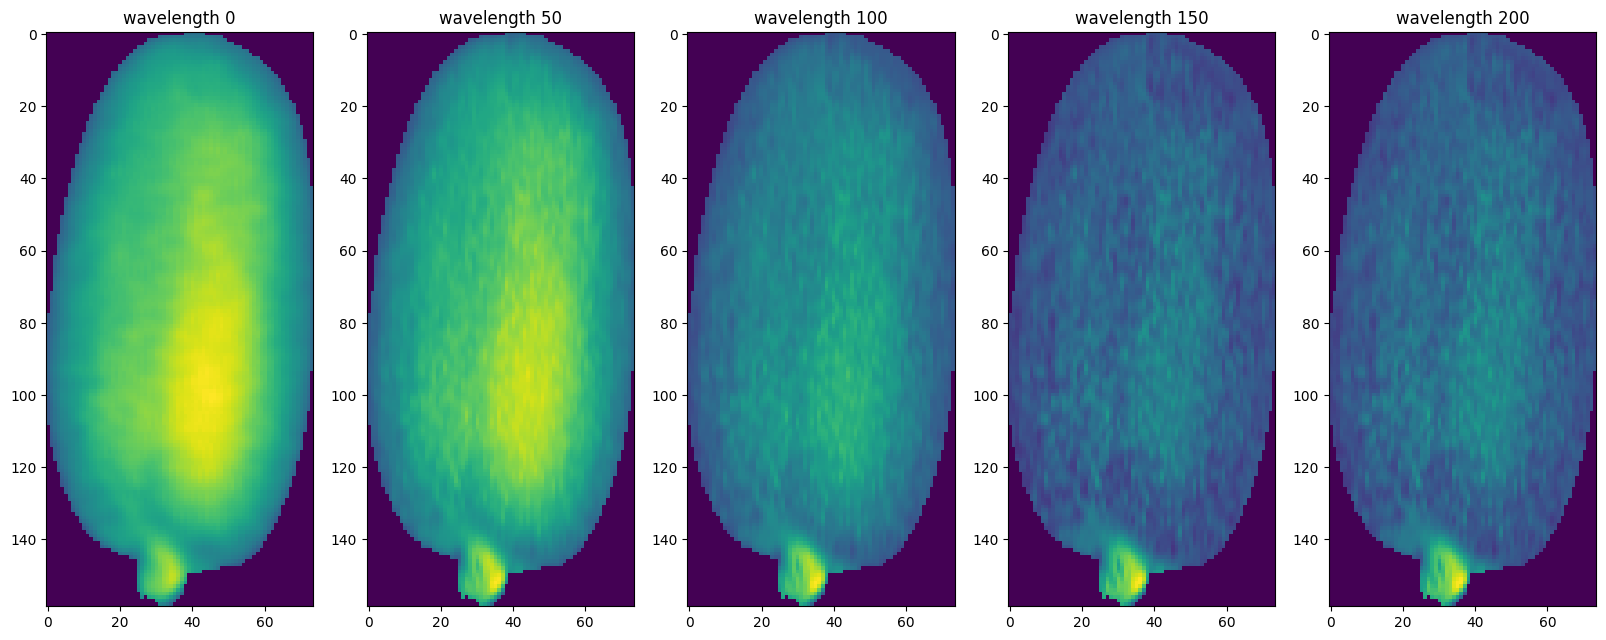

In [13]:
import spectral.io.envi as envi
# example of loading a single image
img = envi.open('./Kiwi/NIR/day_01/kiwi_day_01_01_back.hdr', './Kiwi/NIR/day_01/kiwi_day_01_01_back.bin')
print(img.shape)
print(img)
# show the image
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
axs[0].imshow(img[:,:,0])
axs[0].set_title('wavelength 0')
axs[1].imshow(img[:,:,50])
axs[1].set_title('wavelength 50')
axs[2].imshow(img[:,:,100])
axs[2].set_title('wavelength 100')
axs[3].imshow(img[:,:,150])
axs[3].set_title('wavelength 150')
axs[4].imshow(img[:,:,200])
axs[4].set_title('wavelength 200')
plt.show()

Before we can proceed lets check the sizes of each image in the dataset

In [14]:
# train dataset 
# we will do this by iterating through the records and loading the images extracting the size and noting it in the dataframe
# we will also extract the number of bands and note it in the dataframe

def get_Img_size(row):
    img = envi.open(row['header_file'], row['data_file'])
    return img.shape

train_df['img_shape'] = train_df.apply(get_Img_size, axis=1)
val_df['img_shape'] = val_df.apply(get_Img_size, axis=1)
test_df['img_shape'] = test_df.apply(get_Img_size, axis=1)

train_df.head()

,id,fruit,side,day,camera_type,header_file,data_file,record_id,init_weight,end_weight,storage_days,firmness,comment,ripeness_state,ripeness_state_fine,img_shape
0,0,Avocado,front,day_01,NIR,Avocado/NIR/day_01/avocado_day_01_20_front.hdr,Avocado/NIR/day_01/avocado_day_01_20_front.bin,0,227,227.0,0,19750.0,None,unripe,unripe,"(219, 94, 252)"
1,1,Avocado,front,day_01,VIS,Avocado/VIS/day_01/avocado_day_01_20_front.hdr,Avocado/VIS/day_01/avocado_day_01_20_front.bin,1,227,227.0,0,19750.0,None,unripe,unripe,"(286, 294, 224)"
2,2,Avocado,back,day_01,NIR,Avocado/NIR/day_01/avocado_day_01_20_back.hdr,Avocado/NIR/day_01/avocado_day_01_20_back.bin,2,227,227.0,0,19750.0,None,unripe,unripe,"(220, 94, 252)"
3,3,Avocado,back,day_01,VIS,Avocado/VIS/day_01/avocado_day_01_20_back.hdr,Avocado/VIS/day_01/avocado_day_01_20_back.bin,3,227,227.0,0,19750.0,None,unripe,unripe,"(291, 299, 224)"
4,4,Avocado,front,day_01,NIR,Avocado/NIR/day_01/avocado_day_01_30_front.hdr,Avocado/NIR/day_01/avocado_day_01_30_front.bin,4,252,252.0,0,18250.0,None,unripe,unripe,"(278, 93, 252)"


In [16]:
# look at the unique image shapes for each fruit to come to a conclusion about resize dimensions
# get the unique fruits 
unique_fruits = train_df['fruit'].unique()
for fruit in unique_fruits:
    fruit_df = train_df[train_df['fruit'] == fruit]
    # get unique camera wavelengths
    unique_cameras = fruit_df['camera_type'].unique()
    for camera in unique_cameras:
        camera_df = fruit_df[fruit_df['camera_type'] == camera]
        # get unique image shapes
        unique_shapes = camera_df['img_shape'].unique()
        print(f"For {fruit} and {camera} camera, the unique image shapes are: {unique_shapes}")


For Avocado and NIR camera, the unique image shapes are: [(219, 94, 252) (220, 94, 252) (278, 93, 252) (277, 93, 252)
 (245, 182, 252) (241, 182, 252) (243, 212, 252) (240, 209, 252)
 (329, 189, 252) (308, 197, 252) (281, 210, 252) (277, 210, 252)
 (316, 185, 252) (319, 190, 252) (299, 192, 252) (311, 191, 252)
 (337, 190, 252) (329, 190, 252) (363, 178, 252) (361, 186, 252)
 (302, 193, 252) (307, 191, 252) (312, 197, 252) (305, 194, 252)
 (303, 191, 252) (281, 208, 252) (279, 209, 252) (296, 202, 252)
 (287, 201, 252) (289, 200, 252) (315, 188, 252) (311, 186, 252)
 (291, 190, 252) (307, 182, 252) (308, 180, 252) (293, 190, 252)
 (286, 177, 252) (286, 174, 252) (268, 194, 252) (305, 188, 252)]
For Avocado and VIS camera, the unique image shapes are: [(286, 294, 224) (291, 299, 224) (360, 295, 224) (362, 293, 224)
 (311, 265, 224) (307, 268, 224) (306, 311, 224) (307, 309, 224)
 (402, 281, 224) (369, 282, 224) (342, 305, 224) (334, 302, 224)
 (320, 310, 224) (321, 313, 224) (363, 271, 

### Preprocessing

Part 1 : Encoding the Ripeness state of the fruit

In [9]:
# keep dictionary of the ripeness state and the corresponding number
ripeness_state_dict = {'unripe': 0, 'perfect': 1, 'overripe': 2}

In [10]:
# apply it to train val and test dataframes
train_df['ripeness_state_y'] = train_df['ripeness_state'].apply(lambda x: ripeness_state_dict[x])
val_df['ripeness_state_y'] = val_df['ripeness_state'].apply(lambda x: ripeness_state_dict[x])
test_df['ripeness_state_y'] = test_df['ripeness_state'].apply(lambda x: ripeness_state_dict[x])

Part 2 : Encoding the damage state of the fruit

In [18]:
# 1 if damaged 0 if not
train_df["is_damaged"] = train_df["comment"].str.contains("damaged", case=False, na=False).astype(int)
val_df["is_damaged"] = val_df["comment"].str.contains("damaged", case=False, na=False).astype(int)
test_df["is_damaged"] = test_df["comment"].str.contains("damaged", case=False, na=False).astype(int)

Note that the firmness column does not require pre processing

In [19]:
# save dfs as csv files for later use 
train_df.to_csv(os.path.join(working_dir, "train_df.csv"), index=False)
val_df.to_csv(os.path.join(working_dir, "val_df.csv"), index=False)
test_df.to_csv(os.path.join(working_dir, "test_df.csv"), index=False)

## CHECKPOINT
- loads data from csv files
- creates data generators for training, validation and testing

In [4]:
train_df = pd.read_csv(os.path.join(working_dir, "train_df.csv"))
val_df = pd.read_csv(os.path.join(working_dir, "val_df.csv"))
test_df = pd.read_csv(os.path.join(working_dir, "test_df.csv"))

define LOOCV function

In [5]:
def LOOCV(model, dataset, batch_size, epochs=5, augment = False, augConfig = None, balance = False, save_path="", verbose=0):
    # initialise empty list to store the results
    results = []
    # save starting weights of the model
    if not os.path.exists(os.path.join(working_dir, save_path)):
        os.mkdir(os.path.join(working_dir, save_path))
    model.save_weights(os.path.join(working_dir, save_path + f"/{model.__name__}_weights_start.h5"))
    # iterate through the dataset using iterrows
    i=1
    for index, row in dataset.iterrows():
        # reset the model weights
        if verbose:
            print(f"Training model for iteration {i}")
            print("resetting model weights")
        model.load_weights(os.path.join(working_dir, save_path + f"/{model.__name__}_weights_start.h5"))
        # omit the current row from the dataset
        y = row['ripeness_state_y']
        temp_df = dataset.drop(index)
        # get the omitted row as a dataframe
        omitted_df = dataset.iloc[[i]]
        # get the data generator
        temp_datagen = HSI_datagen(temp_df, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=batch_size, target_size=(64, 64), data_dir=data_dir,
                                shuffle=True, normalize=False, augment=augment, augmentConfig=augConfig, balance=balance)
        omitted_datagen = HSI_datagen(omitted_df, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=1, target_size=(64, 64), data_dir=data_dir,
                                shuffle=True, normalize=False)
        # train the model
        model.fit(temp_datagen, epochs=epochs)
        # save the model weights keeping track of iteration number 
        # create a folder, if it does not exist 
        model.save_weights(os.path.join(working_dir, save_path + f"/{model.__name__}_weights_{i}.h5"))
        # evaluate the model
        x, _ = omitted_datagen.__getitem__(0)
        y_pred = model.predict(x)
        y_pred = np.argmax(y_pred, axis=1)
        # compare the predicted value with the actual value
        if y_pred == y:
            if verbose:
                print(f"Correct prediction for iteration {i}")
            results.append(1)
        else:
            if verbose:
                print(f"Incorrect prediction for iteration {i}")
            results.append(0)
        # increment the iteration number
        i+=1
    # return the results
    return results


recall ripeness mapping

In [6]:
ripeness_state_dict = {'unripe': 0, 'perfect': 1, 'overripe': 2}

define augmentation parameters

In [7]:
augConfig = {"keep_original": False, "horizontal_flip": False, "vertical_flip" : True,"rotation_range": 90, "noise":{"type":"poisson","level":0} }

### Avocado Subset 

#### VIS

In [8]:
# get all rows where the camera type is VIS and the fruit is Avocado
train_avocado_VIS = train_df[(train_df['camera_type'] == 'VIS') & (train_df['fruit'] == 'Avocado')]
val_avocado_VIS = val_df[(val_df['camera_type'] == 'VIS') & (val_df['fruit'] == 'Avocado')]
test_avocado_VIS = test_df[(test_df['camera_type'] == 'VIS') & (test_df['fruit'] == 'Avocado')]
all_avocado_VIS = pd.concat([train_avocado_VIS, val_avocado_VIS, test_avocado_VIS])

In [9]:
train_avocado_VIS_datagen = HSI_datagen(train_avocado_VIS, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= True, augmentConfig=augConfig, balance=True)
# 
val_avocado_VIS_datagen = HSI_datagen(val_avocado_VIS, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= False, augmentConfig=augConfig, balance=True)
# 
test_avocado_VIS_datagen = HSI_datagen(test_avocado_VIS, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= False, augmentConfig=augConfig, balance=True)
# 
all_avocado_VIS_datagen = HSI_datagen(all_avocado_VIS, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= False, augmentConfig=augConfig, balance=True)

In [10]:
len(train_avocado_VIS), len(val_avocado_VIS), len(test_avocado_VIS)

(92, 15, 83)

In [19]:
len(all_avocado_VIS)

190

#### NIR

In [8]:
# get all rows where the camera type is NIR and the fruit is Avocado 
train_avocado_NIR = train_df[(train_df['camera_type'] == 'NIR') & (train_df['fruit'] == 'Avocado')]
# apply the same to val and test dataframes
val_avocado_NIR = val_df[(val_df['camera_type'] == 'NIR') & (val_df['fruit'] == 'Avocado')]
test_avocado_NIR = test_df[(test_df['camera_type'] == 'NIR') & (test_df['fruit'] == 'Avocado')]
all_avocado_NIR = pd.concat([train_avocado_NIR, val_avocado_NIR, test_avocado_NIR])

In [35]:
train_avocado_NIR_datagen = HSI_datagen(train_avocado_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= True, augmentConfig=augConfig, balance=True)
# 
val_avocado_NIR_datagen = HSI_datagen(val_avocado_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= False, augmentConfig=augConfig, balance=True)
# 
test_avocado_NIR_datagen = HSI_datagen(test_avocado_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= False, augmentConfig=augConfig, balance=True)
# 
all_avocado_NIR_datagen = HSI_datagen(all_avocado_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False)
# 
all_avocado_NIR_datagen_aug = HSI_datagen(all_avocado_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= True, augmentConfig=augConfig, balance=False)
# 
all_avocado_NIR_datagen_bal = HSI_datagen(all_avocado_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= True, augmentConfig=augConfig, balance=True)

In [10]:
len(train_avocado_NIR), len(val_avocado_NIR), len(test_avocado_NIR)

(40, 9, 9)

In [11]:
len(all_avocado_NIR)

58

### Kiwi Subset

#### VIS 

In [11]:
# get all rows where the camera type is VIS and the fruit is Kiwi
train_kiwi_VIS = train_df[(train_df['camera_type'] == 'VIS') & (train_df['fruit'] == 'Kiwi')]
val_kiwi_VIS = val_df[(val_df['camera_type'] == 'VIS') & (val_df['fruit'] == 'Kiwi')]
test_kiwi_VIS = test_df[(test_df['camera_type'] == 'VIS') & (test_df['fruit'] == 'Kiwi')]
all_kiwi_VIS = pd.concat([train_kiwi_VIS, val_kiwi_VIS, test_kiwi_VIS])

In [12]:
train_kiwi_VIS_datagen = HSI_datagen(train_kiwi_VIS, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= True, augmentConfig=augConfig, balance=True)
#
val_kiwi_VIS_datagen = HSI_datagen(val_kiwi_VIS,'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, balance=True, augmentConfig=augConfig)
#
test_kiwi_VIS_datagen = HSI_datagen(test_kiwi_VIS, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, balance=True, augmentConfig=augConfig)
# 
all_kiwi_VIS_datagen = HSI_datagen(all_kiwi_VIS, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, balance=True, augmentConfig=augConfig)

In [13]:
len(train_kiwi_VIS), len(val_kiwi_VIS), len(test_kiwi_VIS)

(138, 24, 24)

In [14]:
len(all_kiwi_VIS)

186

#### NIR

In [43]:
#  get all rows where the camera type is NIR and the fruit is Kiwi
train_kiwi_NIR = train_df[(train_df['camera_type'] == 'NIR') & (train_df['fruit'] == 'Kiwi')]
# apply the same to the validation and test dataframes
val_kiwi_NIR = val_df[(val_df['camera_type'] == 'NIR') & (val_df['fruit'] == 'Kiwi')]
test_kiwi_NIR = test_df[(test_df['camera_type'] == 'NIR') & (test_df['fruit'] == 'Kiwi')]
all_kiwi_NIR = pd.concat([train_kiwi_NIR, val_kiwi_NIR, test_kiwi_NIR])

In [13]:
train_kiwi_NIR_datagen = HSI_datagen(train_kiwi_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir, 
                           shuffle=True, normalize=False, augment= True, augmentConfig=augConfig, balance=True)
# 
val_kiwi_NIR_datagen = HSI_datagen(val_kiwi_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment= False, augmentConfig=augConfig, balance=True)
#
test_kiwi_NIR_datagen = HSI_datagen(test_kiwi_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=len(test_kiwi_NIR), target_size=(64, 64), data_dir=data_dir, 
                           shuffle=True, normalize=False, augment= False, augmentConfig=augConfig, balance=True)
#
all_kiwi_nir_datagen = HSI_datagen(all_kiwi_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False)
# 
all_kiwi_nir_datagen_aug = HSI_datagen(all_kiwi_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment = True, augmentConfig=augConfig, balance = False)
# 
all_kiwi_nir_datagen_bal = HSI_datagen(all_kiwi_NIR, 'header_file', 'data_file', {'name': 'ripeness_state_y', 'type': int}, batch_size=9, target_size=(64, 64), data_dir=data_dir,
                            shuffle=True, normalize=False, augment = False, augmentConfig=augConfig, balance = True)

In [14]:
len(train_kiwi_NIR), len(val_kiwi_NIR), len(test_kiwi_NIR)

(58, 9, 9)

In [15]:
len(all_kiwi_NIR)

76

## HS_CNN

#### Model Architecture

In [15]:
def build_HSI_CNN(input_shape):
    # Depthwise Convolution Block 1
    HS_CNN = Sequential()
    HS_CNN.add(DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, input_shape=input_shape, depth_multiplier=3))  # depth_multiplier to expand channels
    HS_CNN.add(Conv2D(25, kernel_size=(1, 1), strides=(1, 1), use_bias=True))
    HS_CNN.add(ReLU())
    HS_CNN.add(AveragePooling2D(pool_size=(4, 4), strides=(4, 4)))
    HS_CNN.add(BatchNormalization())
        
    # Depthwise Convolution Block 2
    HS_CNN.add(DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3))  # depth_multiplier to expand channels
    HS_CNN.add(Conv2D(30, kernel_size=(1, 1), strides=(1, 1), use_bias=True))
    HS_CNN.add(ReLU())
    HS_CNN.add(AveragePooling2D(pool_size=(4, 4), strides=(4, 4)))
    HS_CNN.add(BatchNormalization())
        
    # Depthwise Convolution Block 3
    HS_CNN.add(DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3))  # depth_multiplier to expand channels
    HS_CNN.add(Conv2D(50, kernel_size=(1, 1), strides=(1, 1), use_bias=True))
    HS_CNN.add(ReLU())
    HS_CNN.add(BatchNormalization())
    HS_CNN.add(GlobalAveragePooling2D())
        
    HS_CNN.add(Activation('sigmoid'))
        
    # Fully Connected Layer
    HS_CNN.add(BatchNormalization())
    HS_CNN.add(Dense(50, use_bias=True))
    HS_CNN.add(ReLU())
    HS_CNN.add(Dense(3, use_bias=True))
    HS_CNN.add(Activation('sigmoid'))

    HS_CNN.compile(optimizer=AdaBound(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    HS_CNN.__name__ = "HS_CNN"
    #
    return HS_CNN


In [16]:
HS_CNN = build_HSI_CNN((64, 64, 200)) 
HS_CNN.summary()
# plot_model(HS_CNN, to_file='hscnn_plot.png', show_layer_names=False)
# Image('hscnn_plot.png')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwise  (None, 64, 64, 600)      5400      
 Conv2D)                                                         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 25)        15025     
                                                                 
 re_lu (ReLU)                (None, 64, 64, 25)        0         
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 25)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 25)       100       
 ormalization)                                                   
                                                        

#### Avocado Subset (NIR and VIS)

##### NIR

In [17]:
avocado_nir_cb = ModelCheckpoint(filepath = working_dir + 'AVOCADO_NIR_HS_CNN_checkpoints/HS_CNN{epoch:04d}.ckpt', verbose=1, save_freq='epoch', period=5, save_weights_only=True)

In [18]:
avocado_nir_model = build_HSI_CNN((64, 64, 252))

Conventional Training and Testing

In [39]:
# fit 
avocado_nir_model.fit(all_avocado_NIR_datagen_bal, epochs=60, callbacks=[avocado_nir_cb])

Epoch 1/60
6/6 [==============================] - 22s 3s/step - loss: 0.9820 - accuracy: 0.5926
Epoch 2/60
6/6 [==============================] - 15s 2s/step - loss: 0.7332 - accuracy: 0.7407
Epoch 3/60
6/6 [==============================] - 14s 2s/step - loss: 0.6208 - accuracy: 0.7222
Epoch 4/60
6/6 [==============================] - 15s 2s/step - loss: 0.7081 - accuracy: 0.7407
Epoch 5/60
6/6 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.7222
Epoch 5: saving model to C:/Users/aabde/OneDrive - Heriot-Watt University/Bsc Computer Science/Stage 4/Implementation/AVOCADO_NIR_HS_CNN_checkpoints\HS_CNN0005.ckpt
6/6 [==============================] - 14s 2s/step - loss: 0.6432 - accuracy: 0.7222
Epoch 6/60
6/6 [==============================] - 15s 2s/step - loss: 0.5900 - accuracy: 0.7037
Epoch 7/60
6/6 [==============================] - 14s 2s/step - loss: 0.6150 - accuracy: 0.7778
Epoch 8/60
6/6 [==============================] - 14s 2s/step - loss: 0.5165 - acc

In [23]:
# save model history 
with open(os.path.join(working_dir, "avocado_nir_hs_cnn_history.json"), "w") as f:
    json.dump(avocado_nir_model.history.history, f)

now that we found that 30 epochs is enough for the model to converge we can apply LOOCV to the model

In [46]:
avocado_nir_loocv_results = LOOCV(avocado_nir_model, all_avocado_NIR, 9, 60, augment=True, augConfig=augConfig, balance=True, save_path="avocado_nir_hs_cnn_loocv", verbose=1)

Training model for iteration 1
resetting model weights
Epoch 1/60
6/6 [==============================] - 69s 10s/step - loss: 1.2558 - accuracy: 0.3333
Epoch 2/60
6/6 [==============================] - 18s 3s/step - loss: 0.8968 - accuracy: 0.5926
Epoch 3/60
6/6 [==============================] - 16s 3s/step - loss: 0.6394 - accuracy: 0.6852
Epoch 4/60
6/6 [==============================] - 15s 3s/step - loss: 0.6211 - accuracy: 0.7778
Epoch 5/60
6/6 [==============================] - 16s 2s/step - loss: 0.3985 - accuracy: 0.7963
Epoch 6/60
6/6 [==============================] - 16s 3s/step - loss: 0.3795 - accuracy: 0.8704
Epoch 7/60
6/6 [==============================] - 15s 2s/step - loss: 0.4580 - accuracy: 0.8148
Epoch 8/60
6/6 [==============================] - 15s 2s/step - loss: 0.5626 - accuracy: 0.7593
Epoch 9/60
6/6 [==============================] - 15s 3s/step - loss: 0.4671 - accuracy: 0.7593
Epoch 10/60
6/6 [==============================] - 15s 2s/step - loss: 0.4112 - 

KeyboardInterrupt: 

The model achieves 50% accuracy using LOOCV on the NIR subset of the Avocado dataset with 30 epochs of training

##### VIS

Create Image Data Generator and create callback for model checkpointing.

In [19]:
avocado_vis_cb = ModelCheckpoint(filepath = working_dir + 'AVOCADO_VIS_HS_CNN_checkpoints/HS_CNN{epoch:04d}.ckpt', verbose=1, save_freq='epoch', period=5, save_weights_only=True)

In [20]:
avocado_vis_model = build_HSI_CNN((64, 64, 224))

In [22]:
# fit
avocado_vis_model.fit(all_avocado_VIS_datagen, epochs=60, callbacks=[avocado_vis_cb])

Epoch 1/60
21/21 [==============================] - 277s 13s/step - loss: 1.0055 - accuracy: 0.5079
Epoch 2/60
21/21 [==============================] - 248s 12s/step - loss: 0.8050 - accuracy: 0.6667
Epoch 3/60
21/21 [==============================] - 239s 11s/step - loss: 0.7972 - accuracy: 0.6561
Epoch 4/60
21/21 [==============================] - 237s 11s/step - loss: 0.8667 - accuracy: 0.5661
Epoch 5/60
21/21 [==============================] - ETA: 0s - loss: 0.7831 - accuracy: 0.6720 
Epoch 5: saving model to C:/Users/aabde/OneDrive - Heriot-Watt University/Bsc Computer Science/Stage 4/Implementation/AVOCADO_VIS_HS_CNN_checkpoints\HS_CNN0005.ckpt
21/21 [==============================] - 243s 12s/step - loss: 0.7831 - accuracy: 0.6720
Epoch 6/60
21/21 [==============================] - 237s 11s/step - loss: 0.6708 - accuracy: 0.6561
Epoch 7/60
21/21 [==============================] - 247s 12s/step - loss: 0.6270 - accuracy: 0.7619
Epoch 8/60
21/21 [==============================] -

#### Kiwi Subset (NIR and VIS)

##### NIR

create callback for model checkpointing.

In [40]:
kiwi_nir_cb = ModelCheckpoint(filepath = working_dir + 'KIWI_NIR_HS_CNN_checkpoints/HS_CNN{epoch:04d}.ckpt', verbose=1, save_freq='epoch', period=5, save_weights_only=True)

In [41]:
kiwi_nir_model = build_HSI_CNN((64, 64, 252))

In [42]:
kiwi_nir_model.fit(all_kiwi_nir_datagen_bal, epochs=60, callbacks=[kiwi_nir_cb])

Epoch 1/60
8/8 [==============================] - 39s 4s/step - loss: 0.9666 - accuracy: 0.5694
Epoch 2/60
8/8 [==============================] - 13s 2s/step - loss: 0.6678 - accuracy: 0.6806
Epoch 3/60
8/8 [==============================] - 13s 1s/step - loss: 0.5440 - accuracy: 0.7361
Epoch 4/60
8/8 [==============================] - 12s 1s/step - loss: 0.5851 - accuracy: 0.7778
Epoch 5/60
8/8 [==============================] - ETA: 0s - loss: 0.9602 - accuracy: 0.5417
Epoch 5: saving model to C:/Users/aabde/OneDrive - Heriot-Watt University/Bsc Computer Science/Stage 4/Implementation/KIWI_NIR_HS_CNN_checkpoints\HS_CNN0005.ckpt
8/8 [==============================] - 12s 1s/step - loss: 0.9602 - accuracy: 0.5417
Epoch 6/60
8/8 [==============================] - 12s 1s/step - loss: 0.6623 - accuracy: 0.7083
Epoch 7/60
8/8 [==============================] - 12s 1s/step - loss: 0.5399 - accuracy: 0.7361
Epoch 8/60
8/8 [==============================] - 12s 1s/step - loss: 0.6033 - accura

In [27]:
# save model history 
with open(os.path.join(working_dir, "kiwi_nir_hs_cnn_history.json"), "w") as f:
    json.dump(kiwi_nir_model.history.history, f)

In [ ]:
kiwi_nir_loocv_results = LOOCV(kiwi_nir_model, all_kiwi_NIR, 9, 60, "kiwi_nir_hs_cnn_loocv", augment=True, augConfig=augConfig, balance=True, verbose=1)

##### VIS

Create Image Data Generator and create callback for model checkpointing.

In [23]:
kiwi_vis_cb = ModelCheckpoint(filepath = working_dir + 'KIWI_VIS_HS_CNN_checkpoints/HS_CNN{epoch:04d}.ckpt', verbose=1, save_freq='epoch', period=5, save_weights_only=True)

finally train the model

In [24]:
kiwi_vis_model = build_HSI_CNN((64, 64, 224))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d (Depthwise  (None, 64, 64, 672)      6048      
 Conv2D)                                                         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 25)        16825     
                                                                 
 re_lu (ReLU)                (None, 64, 64, 25)        0         
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 25)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 25)       100       
 ormalization)                                                   
                                                        

In [ ]:
# fit
kiwi_vis_model.fit(train_kiwi_VIS_datagen, epochs=150, validation_data=val_kiwi_VIS_datagen, callbacks=[kiwi_vis_cb], use_multiprocessing=True)

## MULTI-SCALE DEPTHWISE CNN (MSDCNN)

Approach 1 : Resizing the input image to different dimensions and passing them through a series of Depthwise convoluional layers which later merges into a shared dense layer which is then propagated to an output layer.
The hidden layers of the model are the same as the HS_CNN model.    

In [2]:
# multi scale depth wise convolutional neural network
def build_MSDCNN(input_shape):
    input_layer = Input(shape=input_shape)

    # original scale pathway
    a = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(input_layer)
    a = Conv2D(25, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(a)
    a = ReLU()(a)
    a = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(a)
    a = BatchNormalization()(a) 
    # Depthwise Convolution Block 2
    a = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(a)  # depth_multiplier to expand channels
    a = Conv2D(30, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(a)
    a = ReLU()(a)
    a = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(a)
    a = BatchNormalization()(a)
    # Depthwise Convolution Block 3
    a = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(a) # depth_multiplier to expand channels
    a = Conv2D(50, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(a)
    a = ReLU()(a)
    a = BatchNormalization()(a)
    a = GlobalAveragePooling2D()(a)

    # double scale pathway 
    def resize_double(input_img):
        return resize_images(input_img, height_factor=2, width_factor=2, data_format='channels_last')
    b = Lambda(resize_double)(input_layer)
    b = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(b)
    b = Conv2D(25, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(b)
    b = ReLU()(b)
    b = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(b)
    b = BatchNormalization()(b)
    # Depthwise Convolution Block 2
    b = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(b)  # depth_multiplier to expand channels
    b = Conv2D(30, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(b)
    b = ReLU()(b)
    b = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(b)
    b = BatchNormalization()(b)
    # Depthwise Convolution Block 3
    b = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(b)  # depth_multiplier to expand channels
    b = Conv2D(50, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(b)
    b = ReLU()(b)
    b = BatchNormalization()(b)
    b = GlobalAveragePooling2D()(b)

    # half scale pathway 
    def resize_half(input_img):
        # return resize_images(input_img, height_factor=0.5, width_factor=0.5, data_format='channels_last')
        # get image shape 
        shape = input_img.shape
        x = shape[1]//2 
        y = shape[2]//2 
        return tf.image.resize(input_img, (x,y))
    c = Lambda(resize_half)(input_layer)
    c = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(c)
    c = Conv2D(25, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(c)
    c = ReLU()(c)
    c = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(c)
    c = BatchNormalization()(c)
    # Depthwise Convolution Block 2
    c = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(c)  # depth_multiplier to expand channels
    c = Conv2D(30, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(c)
    c = ReLU()(c)
    c = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(c)
    c = BatchNormalization()(c)
    # Depthwise Convolution Block 3
    c = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(c)  # depth_multiplier to expand channels
    c = Conv2D(50, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(c)
    c = ReLU()(c)
    c = BatchNormalization()(c)
    c = GlobalAveragePooling2D()(c)

    # concatenate the three pathways
    x = concatenate([a, b, c])
    x = Activation('sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(150, use_bias=True)(x)
    x = ReLU()(x)
    x = Dense(3, use_bias=True)(x)
    x = Activation('sigmoid')(x)
    
    model = keras.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-2, beta_1=0.5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [3]:
MSDCNN = build_MSDCNN((64, 64, 224))
MSDCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 224  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 22  0           ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 32, 32, 224)  0           ['input_1[0][0]']                
                                                                                              

#### Avocado Subset (NIR and VIS)

##### NIR

##### VIS

#### Kiwi Subset (NIR and VIS)

##### NIR

In [27]:
kiwi_nir_msdcnn_cb = ModelCheckpoint(filepath = working_dir + 'KIWI_NIR_MSDCNN1_checkpoints/MSDCNN1{epoch:04d}.ckpt', verbose=1, save_freq='epoch', period=5, save_weights_only=True)

In [28]:
kiwi_nir_msdcnn = build_MSDCNN((64, 64, 252))

In [29]:
kiwi_nir_msdcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 252  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 25  0           ['input_2[0][0]']                
                                2)                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 32, 32, 252)  0           ['input_2[0][0]']                
                                                                                            

In [30]:
kiwi_nir_msdcnn.fit(train_kiwi_NIR_datagen, epochs=60, validation_data=val_kiwi_NIR_datagen, callbacks=[kiwi_nir_msdcnn_cb])

unique classes: [1 0 2]
class 1 was over the max count of 3 samples, 6 samples were found
class 0 was under the max count of 3 samples, 1 samples were found
class 2 was under the max count of 3 samples, 2 samples were found
Epoch 1/150
6/6 [==============================] - ETA: 0s - loss: 1.2576 - accuracy: 0.5556unique classes: [2 0 1]
class 2 is already balanced
class 0 is already balanced
class 1 is already balanced
6/6 [==============================] - 103s 14s/step - loss: 1.2576 - accuracy: 0.5556 - val_loss: 1.3170 - val_accuracy: 0.3333
Epoch 2/150
6/6 [==============================] - 81s 11s/step - loss: 1.3087 - accuracy: 0.5926 - val_loss: 1.1654 - val_accuracy: 0.3333
Epoch 3/150
6/6 [==============================] - 85s 13s/step - loss: 0.6597 - accuracy: 0.7593 - val_loss: 1.0969 - val_accuracy: 0.3333
Epoch 4/150
6/6 [==============================] - 68s 10s/step - loss: 1.0491 - accuracy: 0.6111 - val_loss: 1.1201 - val_accuracy: 0.3333
Epoch 5/150
6/6 [==========

evaluate the model on test dataset

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 76ms/step
Epoch 5 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.00      0.00      0.00         3
     perfect       0.33      1.00      0.50         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



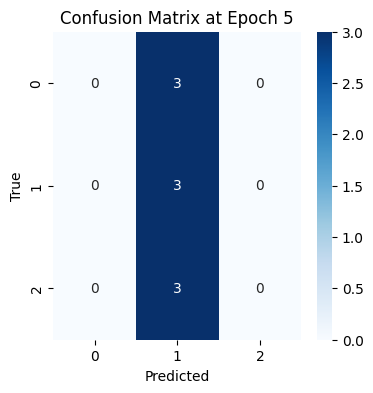

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 67ms/step
Epoch 10 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.00      0.00      0.00         3
     perfect       0.33      1.00      0.50         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



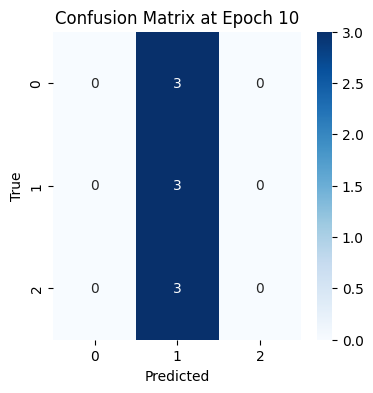

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 81ms/step
Epoch 15 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.33      1.00      0.50         3
     perfect       0.00      0.00      0.00         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



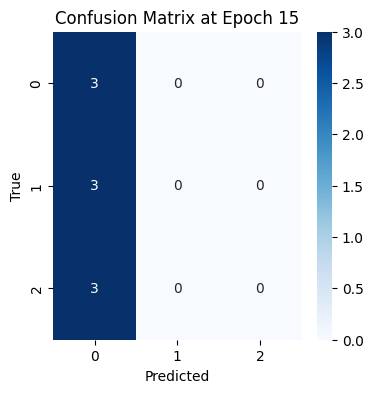

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 55ms/step
Epoch 20 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.00      0.00      0.00         3
     perfect       0.33      1.00      0.50         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



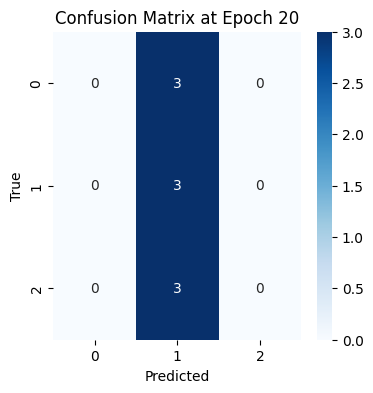

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 46ms/step
Epoch 25 Accuracy: 0.4444444444444444
              precision    recall  f1-score   support

      unripe       0.38      1.00      0.55         3
     perfect       1.00      0.33      0.50         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.44         9
   macro avg       0.46      0.44      0.35         9
weighted avg       0.46      0.44      0.35         9



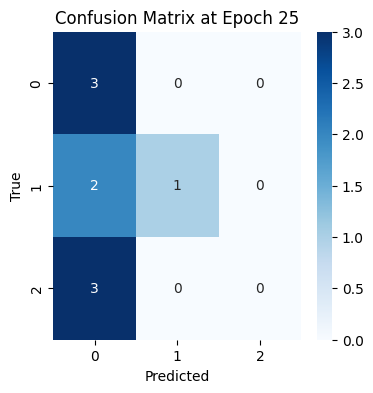

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 62ms/step
Epoch 30 Accuracy: 0.4444444444444444
              precision    recall  f1-score   support

      unripe       0.43      1.00      0.60         3
     perfect       0.50      0.33      0.40         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.44         9
   macro avg       0.31      0.44      0.33         9
weighted avg       0.31      0.44      0.33         9



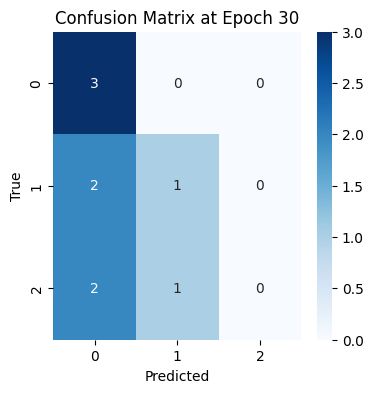

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 54ms/step
Epoch 35 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.00      0.00      0.00         3
     perfect       0.38      1.00      0.55         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.12      0.33      0.18         9
weighted avg       0.12      0.33      0.18         9



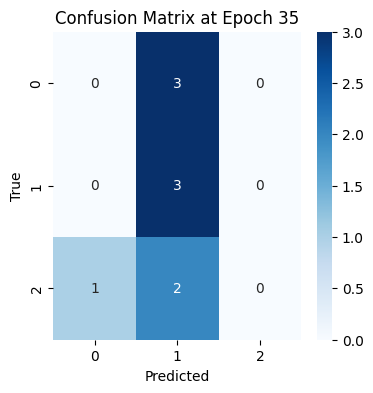

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 51ms/step
Epoch 40 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.33      1.00      0.50         3
     perfect       0.00      0.00      0.00         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



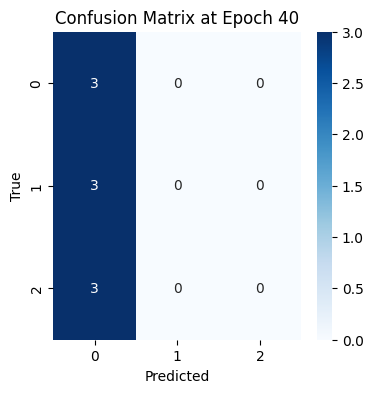

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 56ms/step
Epoch 45 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.38      1.00      0.55         3
     perfect       0.00      0.00      0.00         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.12      0.33      0.18         9
weighted avg       0.12      0.33      0.18         9



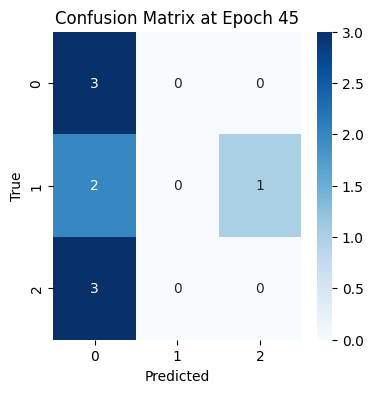

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 47ms/step
Epoch 50 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.50      0.67      0.57         3
     perfect       0.00      0.00      0.00         3
    overripe       0.20      0.33      0.25         3

    accuracy                           0.33         9
   macro avg       0.23      0.33      0.27         9
weighted avg       0.23      0.33      0.27         9



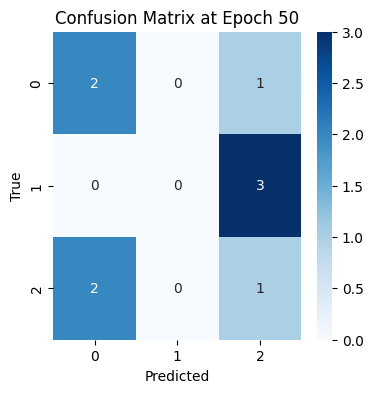

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 51ms/step
Epoch 55 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.33      1.00      0.50         3
     perfect       0.00      0.00      0.00         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



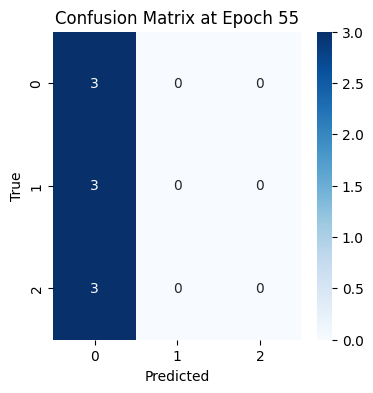

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 56ms/step
Epoch 60 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.33      1.00      0.50         3
     perfect       0.00      0.00      0.00         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



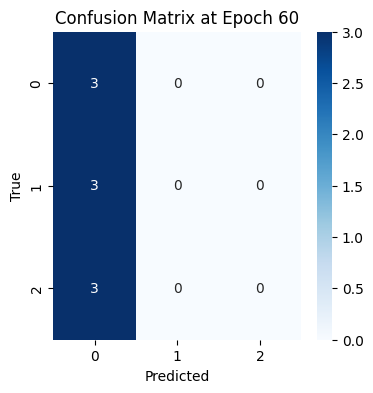

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 48ms/step
Epoch 65 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.50      0.67      0.57         3
     perfect       0.00      0.00      0.00         3
    overripe       0.20      0.33      0.25         3

    accuracy                           0.33         9
   macro avg       0.23      0.33      0.27         9
weighted avg       0.23      0.33      0.27         9



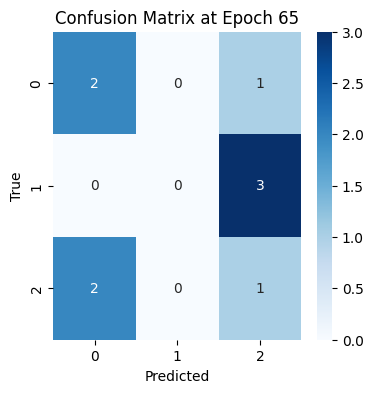

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 48ms/step
Epoch 70 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.33      1.00      0.50         3
     perfect       0.00      0.00      0.00         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



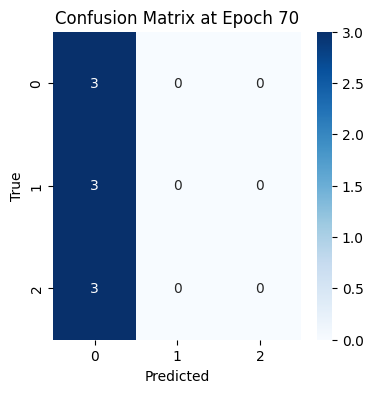

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 47ms/step
Epoch 75 Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

      unripe       0.40      0.67      0.50         3
     perfect       0.67      0.67      0.67         3
    overripe       1.00      0.33      0.50         3

    accuracy                           0.56         9
   macro avg       0.69      0.56      0.56         9
weighted avg       0.69      0.56      0.56         9



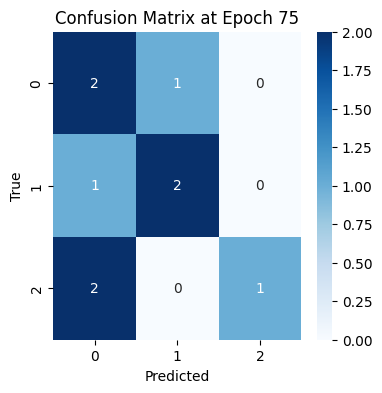

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 48ms/step
Epoch 80 Accuracy: 0.2222222222222222
              precision    recall  f1-score   support

      unripe       0.50      0.33      0.40         3
     perfect       0.00      0.00      0.00         3
    overripe       0.20      0.33      0.25         3

    accuracy                           0.22         9
   macro avg       0.23      0.22      0.22         9
weighted avg       0.23      0.22      0.22         9



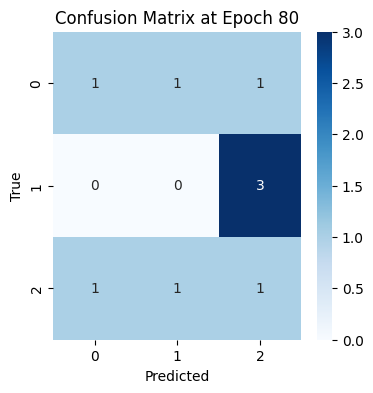

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 46ms/step
Epoch 85 Accuracy: 0.4444444444444444
              precision    recall  f1-score   support

      unripe       0.67      0.67      0.67         3
     perfect       0.50      0.33      0.40         3
    overripe       0.25      0.33      0.29         3

    accuracy                           0.44         9
   macro avg       0.47      0.44      0.45         9
weighted avg       0.47      0.44      0.45         9



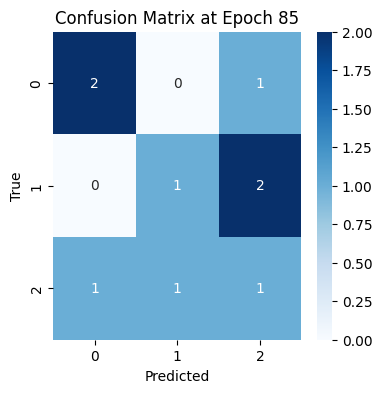

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 49ms/step
Epoch 90 Accuracy: 0.2222222222222222
              precision    recall  f1-score   support

      unripe       0.50      0.33      0.40         3
     perfect       0.00      0.00      0.00         3
    overripe       0.20      0.33      0.25         3

    accuracy                           0.22         9
   macro avg       0.23      0.22      0.22         9
weighted avg       0.23      0.22      0.22         9



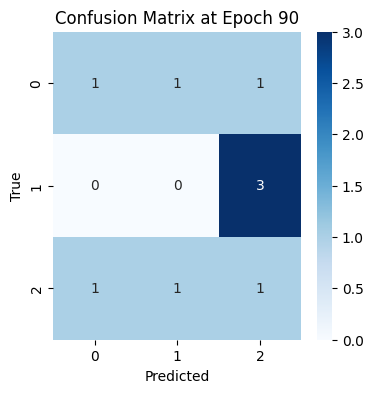

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 42ms/step
Epoch 95 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.50      0.33      0.40         3
     perfect       0.00      0.00      0.00         3
    overripe       0.29      0.67      0.40         3

    accuracy                           0.33         9
   macro avg       0.26      0.33      0.27         9
weighted avg       0.26      0.33      0.27         9



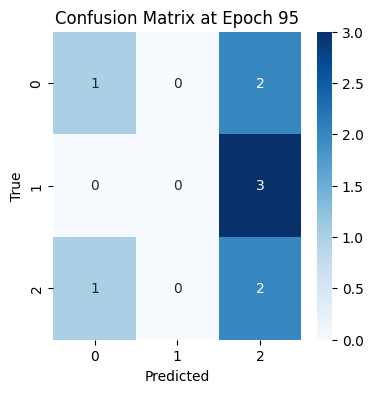

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 49ms/step
Epoch 100 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.00      0.00      0.00         3
     perfect       0.38      1.00      0.55         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.12      0.33      0.18         9
weighted avg       0.12      0.33      0.18         9



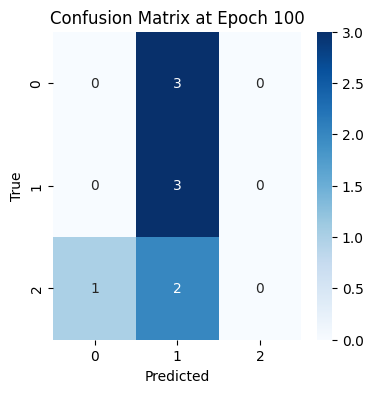

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 48ms/step
Epoch 105 Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

      unripe       0.67      0.67      0.67         3
     perfect       0.50      1.00      0.67         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.56         9
   macro avg       0.39      0.56      0.44         9
weighted avg       0.39      0.56      0.44         9



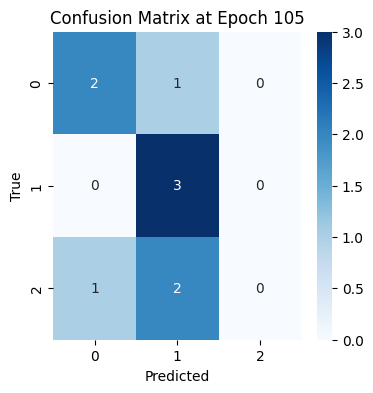

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 44ms/step
Epoch 110 Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

      unripe       0.67      0.67      0.67         3
     perfect       0.50      1.00      0.67         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.56         9
   macro avg       0.39      0.56      0.44         9
weighted avg       0.39      0.56      0.44         9



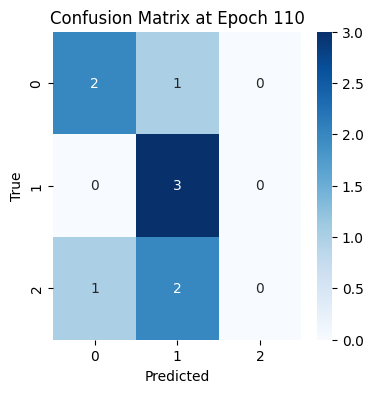

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 48ms/step
Epoch 115 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.00      0.00      0.00         3
     perfect       0.33      1.00      0.50         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



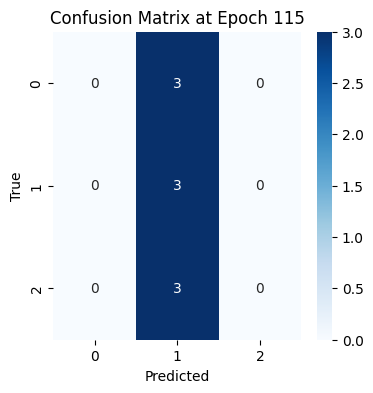

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 46ms/step
Epoch 120 Accuracy: 0.2222222222222222
              precision    recall  f1-score   support

      unripe       0.00      0.00      0.00         3
     perfect       0.29      0.67      0.40         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.22         9
   macro avg       0.10      0.22      0.13         9
weighted avg       0.10      0.22      0.13         9



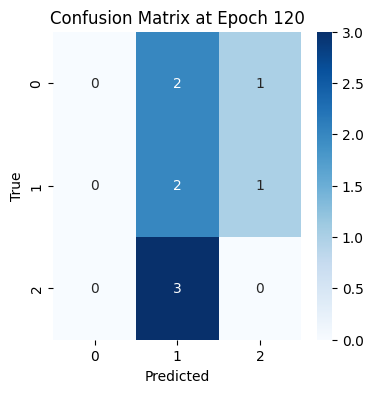

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 48ms/step
Epoch 125 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.33      1.00      0.50         3
     perfect       0.00      0.00      0.00         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.33         9
   macro avg       0.11      0.33      0.17         9
weighted avg       0.11      0.33      0.17         9



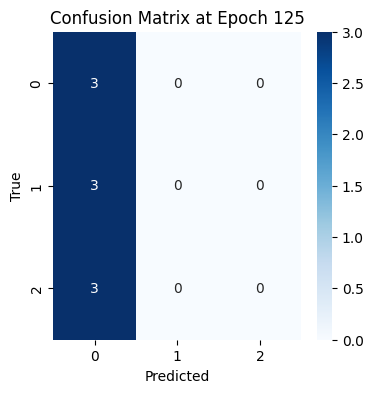

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 46ms/step
Epoch 130 Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

      unripe       0.50      1.00      0.67         3
     perfect       1.00      0.67      0.80         3
    overripe       1.00      0.33      0.50         3

    accuracy                           0.67         9
   macro avg       0.83      0.67      0.66         9
weighted avg       0.83      0.67      0.66         9



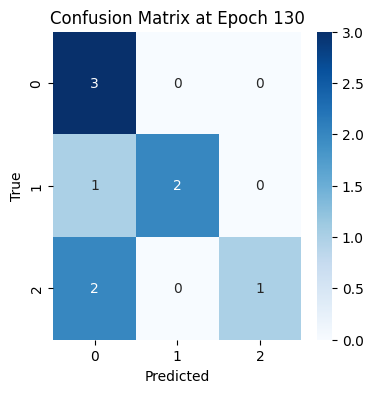

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 45ms/step
Epoch 135 Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

      unripe       0.50      1.00      0.67         3
     perfect       0.67      0.67      0.67         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.56         9
   macro avg       0.39      0.56      0.44         9
weighted avg       0.39      0.56      0.44         9



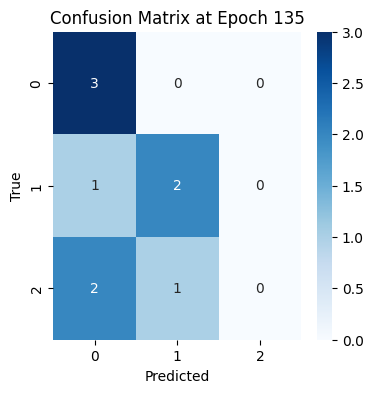

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 52ms/step
Epoch 140 Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

      unripe       0.60      1.00      0.75         3
     perfect       0.75      1.00      0.86         3
    overripe       0.00      0.00      0.00         3

    accuracy                           0.67         9
   macro avg       0.45      0.67      0.54         9
weighted avg       0.45      0.67      0.54         9



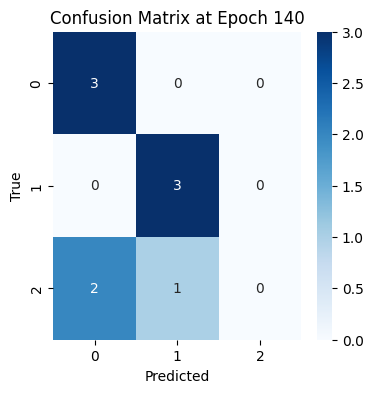

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 47ms/step
Epoch 145 Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      unripe       0.50      0.33      0.40         3
     perfect       0.00      0.00      0.00         3
    overripe       0.33      0.67      0.44         3

    accuracy                           0.33         9
   macro avg       0.28      0.33      0.28         9
weighted avg       0.28      0.33      0.28         9



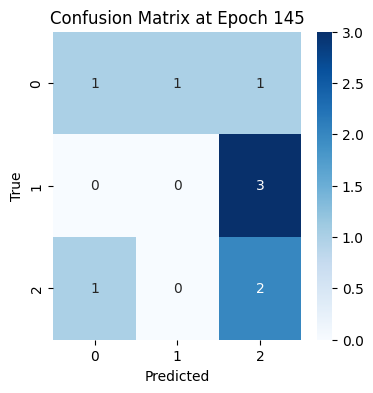

unique classes: [2 1 0]
class 2 is already balanced
class 1 is already balanced
class 0 is already balanced
1/1 [==============================] - 0s 47ms/step
Epoch 150 Accuracy: 0.5555555555555556
              precision    recall  f1-score   support

      unripe       0.50      0.67      0.57         3
     perfect       0.67      0.67      0.67         3
    overripe       0.50      0.33      0.40         3

    accuracy                           0.56         9
   macro avg       0.56      0.56      0.55         9
weighted avg       0.56      0.56      0.55         9



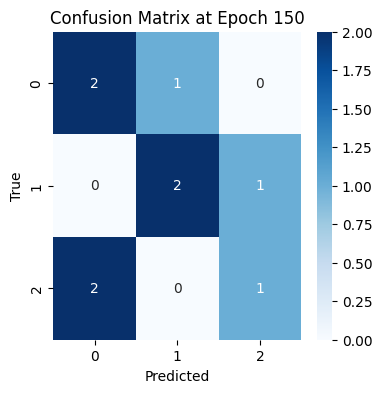

In [49]:
for i in range(5,151,5):
    kiwi_nir_msdcnn.load_weights(working_dir + 'KIWI_NIR_MSDCNN1_checkpoints/MSDCNN1' + str(i).zfill(4) + '.ckpt')
    x, y = test_kiwi_NIR_datagen.__getitem__(0)
    y_pred = kiwi_nir_msdcnn.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    y = y.numpy()
    print(f"Epoch {i} Accuracy: {np.mean(y_pred == y)}")
    # print recall and precision and f1 score
    print(classification_report(y, y_pred, target_names=ripeness_state_dict.keys(), zero_division=0))
    # plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix at Epoch {i}')
    plt.show()

##### VIS

## MULTI-KERNEL DEPTHWISE CNN (MKDCNN)

In [4]:
def build_MKDCNN(input_shape, depth_multiplier=3):
    # Input Layer
    input_layer = Input(shape=input_shape)

    # Fine Scale Path
    a = DepthwiseConv2D(kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(input_layer)
    a = Conv2D(25, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=True)(a)
    a = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(a)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    # Medium Scale Path
    b = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(input_layer)
    b = Conv2D(25, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=True)(b)
    b = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(b)
    b = BatchNormalization()(b)
    b = ReLU()(b)

    # Coarse Scale Path
    c = DepthwiseConv2D(kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False)(input_layer)
    c = Conv2D(25, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=True)(c)
    c = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(c)
    c = BatchNormalization()(c)
    c = ReLU()(c)

    # Feature Fusion
    x = concatenate([a, b, c])  
    x = GlobalAveragePooling2D()(x)
    x = Activation('sigmoid')(x)  
    x = BatchNormalization()(x)
    x = Dense(50, use_bias=True)(x)
    x = ReLU()(x)

    # Output Layer
    x = Dense(3, activation='softmax')(x)

    model = keras.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
mkdcnn = build_MKDCNN((64, 64, 224))

In [8]:
mkdcnn.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 224  0           []                               
                                )]                                                                
                                                                                                  
 depthwise_conv2d_12 (Depthwise  (None, 64, 64, 224)  224        ['input_3[0][0]']                
 Conv2D)                                                                                          
                                                                                                  
 depthwise_conv2d_13 (Depthwise  (None, 64, 64, 224)  2016       ['input_3[0][0]']                
 Conv2D)                                                                                    

#### Avocado Subset (NIR and VIS)

##### NIR

##### VIS

#### Kiwi Subset (NIR and VIS)

##### NIR

First create callbacks 

In [33]:
kiwi_nir_mkdcnn_cb = ModelCheckpoint(filepath = working_dir + 'KIWI_NIR_MKDCNN_checkpoints/MSDCNN4{epoch:04d}.ckpt', verbose=1, save_freq='epoch', period=5, save_weights_only=True)

In [34]:
kiwi_nir_mkdcnn = build_MKDCNN((64, 64, 252))

In [35]:
kiwi_nir_mkdcnn.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 252  0           []                               
                                )]                                                                
                                                                                                  
 depthwise_conv2d_27 (Depthwise  (None, 64, 64, 252)  252        ['input_5[0][0]']                
 Conv2D)                                                                                          
                                                                                                  
 depthwise_conv2d_28 (Depthwise  (None, 64, 64, 252)  2268       ['input_5[0][0]']                
 Conv2D)                                                                                    

In [22]:
kiwi_nir_mkdcnn.fit(train_kiwi_NIR_datagen, epochs=150, validation_data=val_kiwi_NIR_datagen, callbacks=[kiwi_nir_mkdcnn_cb,])

unique classes: [1 0 2]
class 1 was over the max count of 3 samples, 5 samples were found
class 0 was under the max count of 3 samples, 1 samples were found
class 2 is already balanced
Epoch 1/150
6/6 [==============================] - 55s 8s/step - loss: 0.2054 - accuracy: 0.9444 - val_loss: 2.1048 - val_accuracy: 0.3333
Epoch 2/150
6/6 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.8704
Epoch 2: saving model to C:/Users/aabde/OneDrive - Heriot-Watt University/Bsc Computer Science/Stage 4/Implementation/KIWI_NIR_MSDCNN4_checkpoints\MSDCNN40002.ckpt
6/6 [==============================] - 90s 14s/step - loss: 0.4307 - accuracy: 0.8704 - val_loss: 1.6545 - val_accuracy: 0.3333
Epoch 3/150
6/6 [==============================] - 64s 8s/step - loss: 0.2916 - accuracy: 0.8519 - val_loss: 1.8916 - val_accuracy: 0.3333
Epoch 4/150
6/6 [==============================] - 39s 5s/step - loss: 0.3298 - accuracy: 0.8148 - val_loss: 3.2595 - val_accuracy: 0.3333
Epoch 5/150
6

##### VIS

## MKDCNN with Attention

In [9]:
def build_MKDCNN_Attention(input_shape):
    # Input Layer
    input_layer = Input(shape=input_shape)

    # Fine Scale Path
    a = DepthwiseConv2D(kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(input_layer)
    a = Conv2D(30, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=True)(a)
    a = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(a)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    # Medium Scale Path
    b = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(input_layer)
    b = Conv2D(30, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=True)(b)
    b = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(b)
    b = BatchNormalization()(b)
    b = ReLU()(b)

    # Coarse Scale Path
    c = DepthwiseConv2D(kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False)(input_layer)
    c = Conv2D(30, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=True)(c)
    c = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(c)
    c = BatchNormalization()(c)
    c = ReLU()(c)

    # Feature Fusion
    x = Attention()([a, b, c])  
    x = GlobalAveragePooling2D()(x)
    x = Activation('sigmoid')(x)  
    x = BatchNormalization()(x)
    x = Dense(50, use_bias=True)(x)
    x = ReLU()(x)

    # Output Layer
    x = Dense(3, activation='softmax')(x)

    model = keras.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-2, beta_1=0.5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
MKDCNN = build_MKDCNN_Attention((64, 64, 224))

In [11]:
MKDCNN.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 224  0           []                               
                                )]                                                                
                                                                                                  
 depthwise_conv2d_15 (Depthwise  (None, 64, 64, 224)  224        ['input_4[0][0]']                
 Conv2D)                                                                                          
                                                                                                  
 depthwise_conv2d_16 (Depthwise  (None, 64, 64, 224)  2016       ['input_4[0][0]']                
 Conv2D)                                                                                    

In [13]:
kiwi_nir_mkdcnn_attention_cb = ModelCheckpoint(filepath = working_dir + 'KIWI_NIR_MKDCNN_attention_checkpoints/MKDCNN{epoch:04d}.ckpt', verbose=1, save_freq='epoch', period=5, save_weights_only=True)

In [14]:
kiwi_nir_mkdcnn_attention = build_MKDCNN_Attention((64, 64, 252))

In [15]:
kiwi_nir_mkdcnn_attention.fit(train_kiwi_NIR_datagen, epochs=150, validation_data=val_kiwi_NIR_datagen, callbacks=[kiwi_nir_mkdcnn_attention_cb], use_multiprocessing=True)

unique classes: [1 0 2]
class 1 was over the max count of 3 samples, 5 samples were found
class 0 was under the max count of 3 samples, 2 samples were found
class 2 was under the max count of 3 samples, 2 samples were found
Epoch 1/150
6/6 [==============================] - ETA: 0s - loss: 0.9969 - accuracy: 0.5185unique classes: [2 0 1]
class 2 is already balanced
class 0 is already balanced
class 1 is already balanced
6/6 [==============================] - 93s 12s/step - loss: 0.9969 - accuracy: 0.5185 - val_loss: 1.2588 - val_accuracy: 0.3333
Epoch 2/150
6/6 [==============================] - 83s 11s/step - loss: 0.7948 - accuracy: 0.6667 - val_loss: 1.3636 - val_accuracy: 0.3333
Epoch 3/150
6/6 [==============================] - 74s 10s/step - loss: 0.7812 - accuracy: 0.6852 - val_loss: 1.4036 - val_accuracy: 0.3333
Epoch 4/150
6/6 [==============================] - 85s 11s/step - loss: 0.6043 - accuracy: 0.7222 - val_loss: 1.4726 - val_accuracy: 0.3333
Epoch 5/150
6/6 [===========

In [18]:
#  get lowest loss 
min_loss = np.min(kiwi_nir_mkdcnn_attention.history.history['loss'])
min_loss 

0.012262016534805298

In [20]:
# save history 
import pickle
with open(working_dir + 'kiwi_nir_mkdcnn_attention_history.pkl', 'wb') as f:
    pickle.dump(kiwi_nir_mkdcnn_attention.history.history, f)

## MSDCNN with Attention

In [12]:
def build_MSDCNN_Attention(input_shape):
    # multi scale depth wise convolutional neural network
    input_layer = Input(shape=input_shape)

    # original scale pathway
    a = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(input_layer)
    a = Conv2D(25, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(a)
    a = ReLU()(a)
    a = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(a)
    a = BatchNormalization()(a) 
    # Depthwise Convolution Block 2
    a = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(a)  # depth_multiplier to expand channels
    a = Conv2D(30, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(a)
    a = ReLU()(a)
    a = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(a)
    a = BatchNormalization()(a)
    # Depthwise Convolution Block 3
    a = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(a) # depth_multiplier to expand channels
    a = Conv2D(50, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(a)
    a = ReLU()(a)
    a = BatchNormalization()(a)
    a = GlobalAveragePooling2D()(a)

    # double scale pathway 
    def resize_double(input_img):
        return resize_images(input_img, height_factor=2, width_factor=2, data_format='channels_last')
    b = Lambda(resize_double)(input_layer)
    b = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(b)
    b = Conv2D(25, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(b)
    b = ReLU()(b)
    b = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(b)
    b = BatchNormalization()(b)
    # Depthwise Convolution Block 2
    b = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(b)  # depth_multiplier to expand channels
    b = Conv2D(30, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(b)
    b = ReLU()(b)
    b = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(b)
    b = BatchNormalization()(b)
    # Depthwise Convolution Block 3
    b = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(b)  # depth_multiplier to expand channels
    b = Conv2D(50, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(b)
    b = ReLU()(b)
    b = BatchNormalization()(b)
    b = GlobalAveragePooling2D()(b)

    # half scale pathway 
    def resize_half(input_img):
        # return resize_images(input_img, height_factor=0.5, width_factor=0.5, data_format='channels_last')
        # get image shape 
        shape = input_img.shape
        x = shape[1]//2 
        y = shape[2]//2 
        return tf.image.resize(input_img, (x,y))
    c = Lambda(resize_half)(input_layer)
    c = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(c)
    c = Conv2D(25, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(c)
    c = ReLU()(c)
    c = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(c)
    c = BatchNormalization()(c)
    # Depthwise Convolution Block 2
    c = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(c)  # depth_multiplier to expand channels
    c = Conv2D(30, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(c)
    c = ReLU()(c)
    c = AveragePooling2D(pool_size=(4, 4), strides=(4, 4))(c)
    c = BatchNormalization()(c)
    # Depthwise Convolution Block 3
    c = DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, depth_multiplier=3)(c)  # depth_multiplier to expand channels
    c = Conv2D(50, kernel_size=(1, 1), strides=(1, 1), use_bias=True)(c)
    c = ReLU()(c)
    c = BatchNormalization()(c)
    c = GlobalAveragePooling2D()(c)

    # concatenate the three pathways
    x = Attention()([a, b, c])
    # x = GlobalAveragePooling2D()(x)
    x = Activation('sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dense(50, use_bias=True)(x)
    x = ReLU()(x)
    x = Dense(3, use_bias=True)(x)
    x = Activation('sigmoid')(x)
    
    model = keras.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-2, beta_1=0.5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
MSDCNN_Attention = build_MSDCNN_Attention((64, 64, 224))

In [15]:
MSDCNN_Attention.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 224  0           []                               
                                )]                                                                
                                                                                                  
 lambda_4 (Lambda)              (None, 128, 128, 22  0           ['input_6[0][0]']                
                                4)                                                                
                                                                                                  
 lambda_5 (Lambda)              (None, 32, 32, 224)  0           ['input_6[0][0]']                
                                                                                            

## Channel Attention and Spatial Attention (CASA)

In [ ]:
def build_CASA(): 
    pass